In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from pixell import enmap, utils
import scipy.signal as ss

In [2]:
def get_cmb_power_spectra(fixed_cosmo=True, r=None):
    """
    Get CMB power spectra from CAMB.

    Parameters
    ----------
    fixed_cosmo : bool
        If False, all cosmo parameters are drawn from random distributions consistent with Planck 2018 I. results.
        If True, we just use the best fit values
    r : float
        Tensor-to-scalar ratio. If None, we draw a random value consistent with constraints from Planck 2018 I. results.
    """
    pars = camb.CAMBparams()

    # From Planck 2018 I. paper Table 7
    H0 = np.random.normal(67.36, 0.54) if not fixed_cosmo else 67.36
    ombh2 = np.random.normal(0.02237, 0.00015) if not fixed_cosmo else 0.02237
    omch2 = np.random.normal(0.12, 0.0012) if not fixed_cosmo else 0.12
    tau = np.random.normal(0.0544, 0.0073) if not fixed_cosmo else 0.0544
    logas = np.random.normal(3.044, 0.014) if not fixed_cosmo else 3.044
    As = np.exp(logas) / 1e10
    ns = np.random.normal(0.9649, 0.0042) if not fixed_cosmo else 0.9649

    # From Planck 2018 I. paper, see Sect. 5.3
    mnu = np.random.uniform(0.06, 0.1) if not fixed_cosmo else 0.8

    # Inspired from the upper limit of Planck 2018 I. paper
    logr = np.random.uniform(-3, -1.494850021680094)
    if r is None:
        r = 10**logr

    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=0, tau=tau)
    pars.InitPower.set_params(As=As, ns=ns, r=r)
    pars.set_for_lmax(4000, lens_potential_accuracy=0)
    pars.WantTensors = True
    results = camb.get_results(pars)
    Cl_TT, Cl_EE, Cl_BB, CL_TE = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)['total'].T
    
    return Cl_TT, Cl_EE, Cl_BB, CL_TE

def patch_shape_and_wcs(Npix, res):
    ndegree_patch = res * Npix / 60
    print(f"Size of the patch in degrees: {ndegree_patch:.2f}")
    box = np.array([[-1, 1], [1, -1]]) * utils.degree * ndegree_patch / 2
    shape, wcs = enmap.geometry(pos=box, res=res*utils.arcmin, proj='car')
    return shape, wcs

In [23]:
pars = camb.CAMBparams()

# From Planck 2018 I. paper Table 7
H0 = np.random.normal(67.36, 0.54) 
ombh2 = np.random.normal(0.02237, 0.00015) 
omch2 = np.random.normal(0.12, 0.0012)
tau = np.random.normal(0.0544, 0.0073) 
logas = np.random.normal(3.044, 0.014)
As = np.exp(logas) / 1e10
ns = np.random.normal(0.9649, 0.0042)

# From Planck 2018 I. paper, see Sect. 5.3
mnu = np.random.uniform(0.06, 0.1)

# Inspired from the upper limit of Planck 2018 I. paper
logr = np.random.uniform(-3, -1.494850021680094)
r = 10**logr

pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=0, tau=tau)
pars.InitPower.set_params(As=As, ns=ns, r=r)
pars.set_for_lmax(4000, lens_potential_accuracy=0)
pars.WantTensors = True


In [24]:
results = camb.get_results(pars)
Cl_TT, Cl_EE, Cl_BB, CL_TE = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)['total'].T

In [3]:
cl_TT, cl_EE, cl_BB, cl_TE = get_cmb_power_spectra(r=0.0)

dl_TT = cl_TT * (np.arange(len(cl_TT)) * (np.arange(len(cl_TT)) + 1)) / (2 * np.pi)
dl_EE = cl_EE * (np.arange(len(cl_EE)) * (np.arange(len(cl_EE)) + 1)) / (2 * np.pi)
dl_BB = cl_BB * (np.arange(len(cl_BB)) * (np.arange(len(cl_BB)) + 1)) / (2 * np.pi)
dl_TE = cl_TE * (np.arange(len(cl_TE)) * (np.arange(len(cl_TE)) + 1)) / (2 * np.pi)

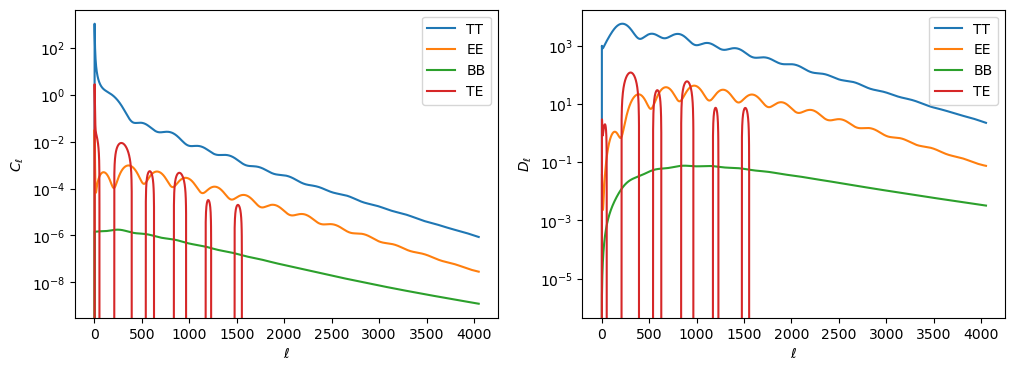

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(cl_TT, label='TT')
axs[0].plot(cl_EE, label='EE')
axs[0].plot(cl_BB, label='BB')
axs[0].plot(cl_TE, label='TE')
axs[0].set_xlabel(r'$\ell$')
axs[0].set_ylabel(r'$C_\ell$')
axs[0].legend()
axs[0].set_yscale('log')
axs[1].plot(dl_TT, label='TT')
axs[1].plot(dl_EE, label='EE')
axs[1].plot(dl_BB, label='BB')
axs[1].plot(dl_TE, label='TE')
axs[1].set_xlabel(r'$\ell$')
axs[1].set_ylabel(r'$D_\ell$')
axs[1].legend()
axs[1].set_yscale('log')
plt.show()

In [5]:
comp = np.zeros((3, 3, cl_TT.shape[-1]))
comp[0,0] = cl_TT
comp[1,1] = cl_EE
comp[0,1] = cl_TE
comp[1,0] = cl_TE
comp[2,2] = cl_BB

In [9]:
Npix = 256    # Number of pixels
res = 8       # Size of a pixel, in arcminutes

shape_patch, wcs_patch = patch_shape_and_wcs(Npix, res)
cmb_maps = enmap.rand_map([3, shape_patch[0], shape_patch[1]], wcs_patch, comp)
print(cmb_maps.shape)
I, Q, U = cmb_maps[0], cmb_maps[1], cmb_maps[2]

Size of the patch in degrees: 34.13
(3, 256, 256)


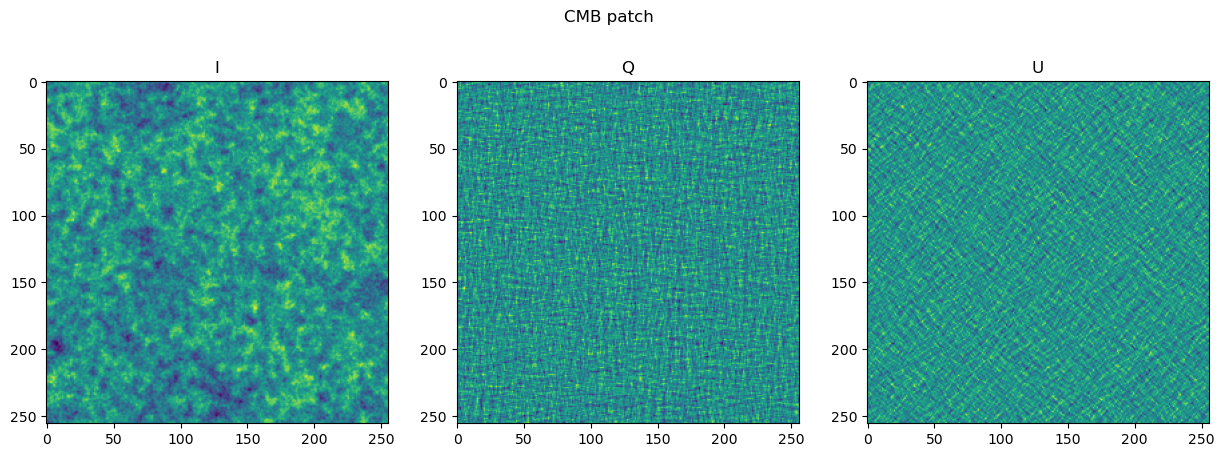

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(I)
axs[1].imshow(Q)
axs[2].imshow(U)
axs[0].set_title("I")
axs[1].set_title("Q")
axs[2].set_title("U")
fig.suptitle("CMB patch")
fig.show()

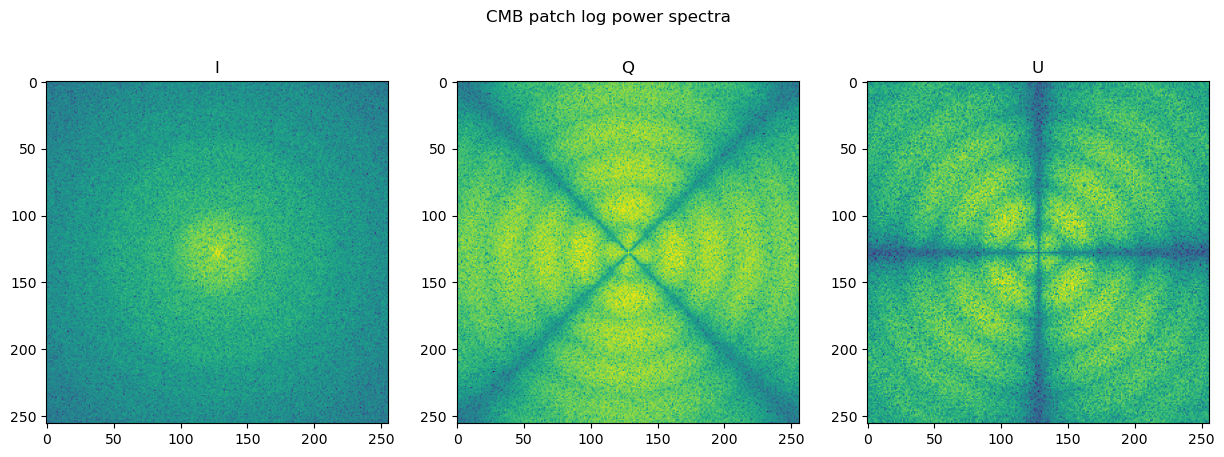

In [54]:
ps_I = np.fft.fftshift(np.absolute(np.fft.fft2(I))**2)
ps_Q = np.fft.fftshift(np.absolute(np.fft.fft2(Q))**2)
ps_U = np.fft.fftshift(np.absolute(np.fft.fft2(U))**2)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(np.log(ps_I))
axs[1].imshow(np.log(ps_Q))
axs[2].imshow(np.log(ps_U))
axs[0].set_title("I")
axs[1].set_title("Q")
axs[2].set_title("U")
fig.suptitle("CMB patch log power spectra")
fig.show()

Size of the patch in degrees: 34.13
(1, 256, 256)


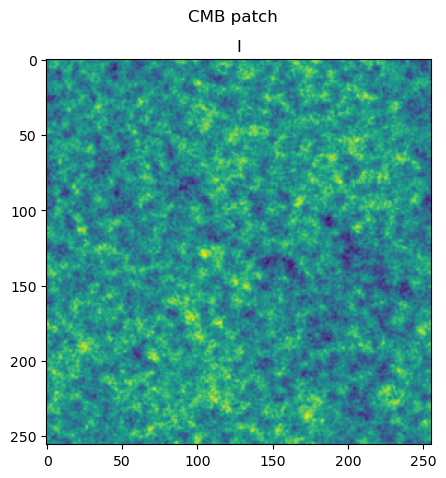

In [181]:
Npix = 256    # Number of pixels
res = 8       # Size of a pixel, in arcminutes

shape_patch, wcs_patch = patch_shape_and_wcs(Npix, res)
cmb_maps = enmap.rand_map([1, shape_patch[0], shape_patch[1]], wcs_patch, comp[0,0])
print(cmb_maps.shape)
I = cmb_maps


fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.imshow(I[0])
axs.set_title("I")
fig.suptitle("CMB patch")
fig.show()

In [8]:
PS = np.zeros((1000,256, 256))
for i in range(1000):
    I = enmap.rand_map([1, shape_patch[0], shape_patch[1]], wcs_patch, comp[0,0])
    PS[i]= np.fft.fftshift(np.absolute(np.fft.fft2(I[0]))**2)/256/256

KeyboardInterrupt: 

In [ ]:
plt.imshow(np.fft.ifft2(np.sqrt()))

In [154]:
meanPS = PS.mean(axis=0)

In [155]:
stdPS = PS.std(axis=0)

In [162]:
(meanPS/10000).mean(), 1.96*(stdPS/10000).mean()/np.sqrt(1000)

(1.1780492885694083, 0.07525984928036955)

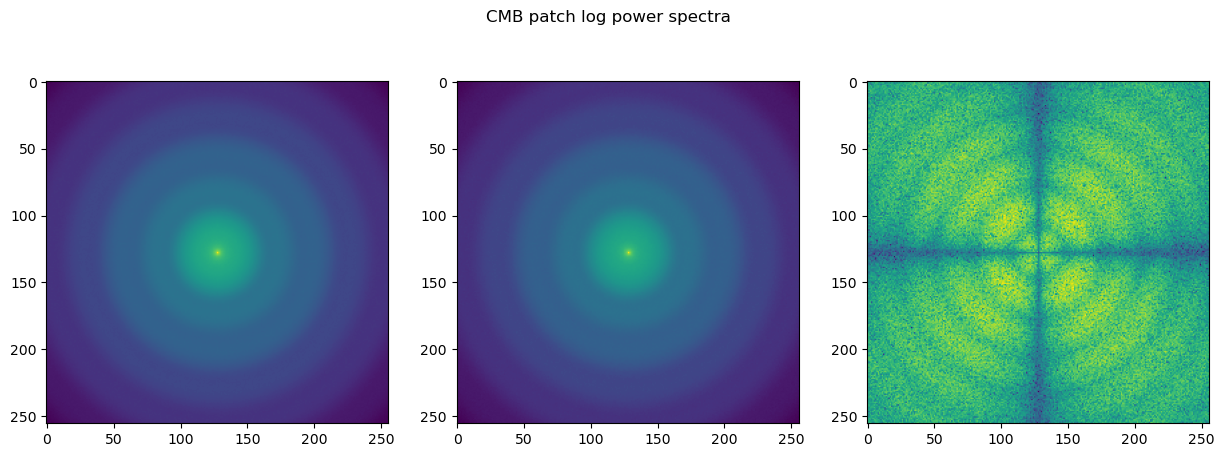

In [164]:
ps_I = np.fft.fftshift(np.absolute(np.fft.fft2(I))**2)
ps_Q = np.fft.fftshift(np.absolute(np.fft.fft2(Q))**2)
ps_U = np.fft.fftshift(np.absolute(np.fft.fft2(U))**2)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(np.log(meanPS))
axs[1].imshow(np.log(stdPS))
axs[2].imshow(np.log(ps_U))
fig.suptitle("CMB patch log power spectra")
fig.show()

In [165]:
PS_ = meanPS/meanPS.mean()

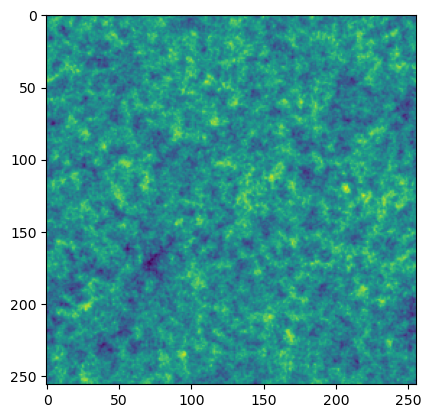

In [183]:
plt.imshow(np.fft.ifft2(np.sqrt(np.fft.ifftshift(PS_))*np.fft.fft2(np.random.randn(256,256))).real)

In [185]:
np.save("/mnt/home/dheurtel/ceph/00_exploration_data/power_spectra/cmb_256_8arcmippixel.npy", np.fft.fftshift(PS_), allow_pickle=True)